# **SubTuringBradBot Trained on the Text of "Slouching Towards Utopia**

**Slightly edited from the notebook of Liam Ottley:**  [YouTube](https://youtube.com/@LiamOttley)





0.   Installs, Imports and API Keys
1.   Loading PDFs and chunking with LangChain
2.   Embedding text and storing embeddings
3.   Creating retrieval function
4.   Creating chatbot with chat memory (OPTIONAL)








# 0. Installs, Imports and API Keys

In [1]:
# RUN THIS CELL FIRST!
!pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/requests-2.22.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/idna-2.8-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/colorama-0.4.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/lark-0.12.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/pytutor-1.0.0-py3.11.egg is deprecated. pip 23.3 will

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Loading PDFs and chunking with LangChain

In [4]:
# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages
loader = PyPDFLoader("./2022-slouching-proof.pdf")
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

page_content='SLOUCHING  \nTOWARDS UTOPIA\n9780465019595_HC1P.indd   19780465019595_HC1P.indd   1 1/11/22   9:47 AM1/11/22   9:47 AM' metadata={'source': './2022-slouching-proof.pdf', 'page': 0}


In [5]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process("./2022-slouching-proof.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('attention_is_all_you_need.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('attention_is_all_you_need.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 768,
    chunk_overlap  = 128,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

In [6]:
# Result is many LangChain 'Documents'
type(chunks[0])

langchain.schema.Document

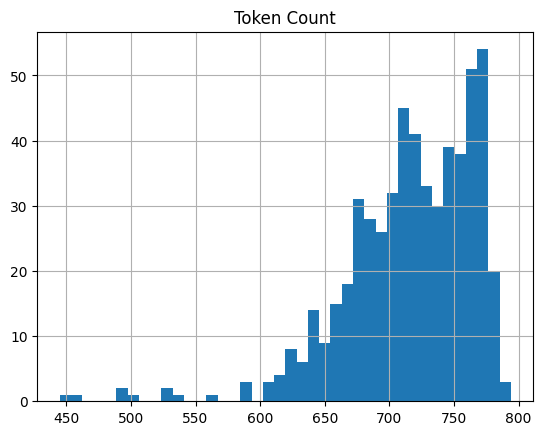

In [7]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

# 2. Embed text and store embeddings

In [8]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

# 3. Setup retrieval function

In [9]:
# Check similarity search is working
query = "What is the Grand Narrative of the book 'Slouching Towards Utopia'?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='1/11/22   9:47 AM\n1/11/22   9:47 AM\n\n\x0cMy Grand Narrative\n\npowerful  reason  why,  even  when  all  went  very  well,  we  only \nslouched rather than galloped toward utopia.\n\nNevertheless,  getting  off  the  treadmill  looks  grim.  Only  a \nfool would wittingly or ignorantly slouch or gallop backward to \nnear-universal dire global poverty.\n\nLET ME REMIND YOU, again, that what follows is a grand narra-\ntive. Of a necessity, I spend chapters on what others have spent \nbooks,  indeed  multiple  volumes,  describing.  In  pursuit  of  big \nthemes, details necessarily suffer. Moreover, I will, as needed—\nwhich will be often—“pull up the roots” and jump far back in \ntime to identify and quickly trace an influential origin story, for \nwe  cannot  do  other  than  think  in  narrative  terms.  What  hap-\npened  in  1500,  say,  had  consequences  for  what  happened  in \n1900. Details, gray areas, controversies, historical uncertainties—\nthey suf

In [10]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "What is the Grand Narrative of the book 'Slouching Towards Utopia'?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

" The Grand Narrative of the book 'Slouching Towards Utopia' is that the long twentieth century saw people in the industrial core of the world economy become far richer than the theorists of previous centuries' utopias could imagine, and this explosion of wealth led to five important processes and sets of forces: history becoming economic, the world globalizing, people transitioning from manufacturing to pushing forward the body of technological and scientific knowledge, people becoming ill-suited for utopia due to the hedonic treadmill, and the struggle for human liberty and prosperity not being decisively and permanently won."

# 5. Create chatbot with chat memory (OPTIONAL)

In [12]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [13]:
chat_history = []
def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you for using the SubTuringBradBot chatbot!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the SubTuringBradBot trained on the text of 'Slouching Towards Utopia'! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='What is your next question?:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the SubTuringBradBot trained on the text of 'Slouching Towards Utopia'! Type 'exit' to stop.


/var/folders/d8/6961hjxn69l6pchnksn1_83w0000gn/T/ipykernel_75023/992488924.py:20: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_box.on_submit(on_submit)


Text(value='', placeholder='What is your next question?:')